Results for k=3 exported to: /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/KNN_Output_files/ratings_predictions_10_knn_uw_k3.csv | RMSE: 1.12
Results for k=5 exported to: /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/KNN_Output_files/ratings_predictions_10_knn_uw_k5.csv | RMSE: 1.07
Results for k=10 exported to: /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/KNN_Output_files/ratings_predictions_10_knn_uw_k10.csv | RMSE: 1.04


IntText(value=1, description='User ID:')

IntText(value=1, description='Movie ID:')

IntSlider(value=3, description='Neighbors:', max=7, min=3, step=2)

Button(description='Recommend', style=ButtonStyle())

Output()

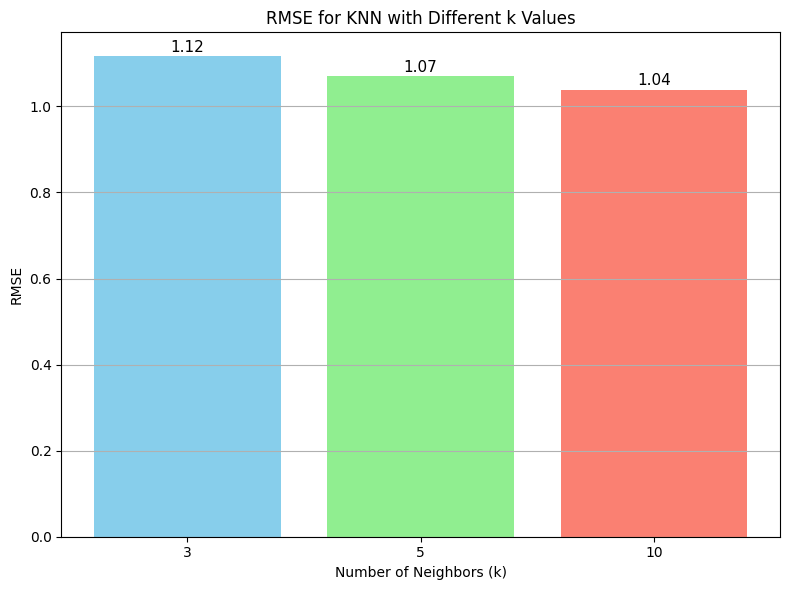

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import sqrt
import matplotlib.pyplot as plt

# Load CSV files containing movie and ratings data
def fetch_data():
    movie_data = pd.read_csv('/Users/aryanpatelkolagani/Downloads/movies.csv')
    rating_data = pd.read_csv('/Users/aryanpatelkolagani/Downloads/ratings.csv')
    return movie_data, rating_data

# Merge data using the common key 'movieId'
def combine_data(movies, ratings):
    return pd.merge(ratings, movies, on='movieId')

# Train the model and calculate RMSE
def evaluate_knn_model(train_data, test_data, k):
    x_train = train_data[['userId', 'movieId']]
    y_train = train_data['rating']
    x_test = test_data[['userId', 'movieId']]

    model = KNeighborsRegressor(n_neighbors=k, weights='uniform', metric='euclidean', n_jobs=-1)
    model.fit(x_train, y_train)

    predictions = model.predict(x_test)
    test_data[f'estimated_rating_k{k}'] = np.round(predictions, 2)

    return sqrt(mean_squared_error(test_data['rating'], test_data[f'estimated_rating_k{k}']))

# Predict and save results to individual CSV files for multiple k values
def run_and_export(train_set, test_set, k_list):
    x_train = train_set[['userId', 'movieId']]
    y_train = train_set['rating']
    x_test = test_set[['userId', 'movieId']]

    for k in k_list:
        knn_model = KNeighborsRegressor(n_neighbors=k, weights='uniform', metric='euclidean', n_jobs=-1)
        knn_model.fit(x_train, y_train)
        pred = knn_model.predict(x_test)
        test_set[f'estimated_rating_k{k}'] = np.round(pred, 2)

        rmse = sqrt(mean_squared_error(test_set['rating'], test_set[f'estimated_rating_k{k}']))
        file_path = f'/Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/KNN_Output_files/ratings_predictions_10_knn_uw_k{k}.csv'
        test_set.to_csv(file_path, columns=['userId', 'movieId', 'rating', f'estimated_rating_k{k}'], index=False)
        print(f'Results for k={k} exported to: {file_path} | RMSE: {rmse:.2f}')

# Load and combine data
movies, ratings = fetch_data()
merged_data = combine_data(movies, ratings)

# Train-test split
train_set, test_set = train_test_split(merged_data, test_size=0.1, random_state=42)

# Generate predictions for specified k values
run_and_export(train_set, test_set.copy(), [3, 5, 10])

# Setup interactive UI for real-time prediction
user_widget = widgets.IntText(value=1, description='User ID:')
movie_widget = widgets.IntText(value=1, description='Movie ID:')
k_widget = widgets.IntSlider(value=3, min=3, max=7, step=2, description='Neighbors:')
recommend_button = widgets.Button(description='Recommend')
output_display = widgets.Output()

# Handle user interaction
def recommend_movie(event):
    with output_display:
        clear_output()
        uid = user_widget.value
        mid = movie_widget.value
        k_val = k_widget.value

        if uid not in train_set['userId'].values:
            print("Invalid user ID.")
            return
        if mid not in train_set['movieId'].values:
            print("Invalid movie ID.")
            return

        x_train = train_set[['userId', 'movieId']]
        y_train = train_set['rating']
        knn = KNeighborsRegressor(n_neighbors=k_val, weights='uniform', metric='euclidean', n_jobs=-1)
        knn.fit(x_train, y_train)

        input_df = pd.DataFrame([[uid, mid]], columns=['userId', 'movieId'])
        estimated_rating = knn.predict(input_df)[0]

        movie_info = movies[movies['movieId'] == mid].to_dict('records')[0]
        print(f"Movie Info: {movie_info}")
        print(f"Predicted Rating (k={k_val}): {estimated_rating:.2f}")

recommend_button.on_click(recommend_movie)

# Display the widgets on screen
display(user_widget, movie_widget, k_widget, recommend_button, output_display)

# RMSE Evaluation Visualization
rmse_results = [evaluate_knn_model(train_set, test_set.copy(), k) for k in [3, 5, 10]]
k_options = [3, 5, 10]
colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(figsize=(8, 6))
plt.bar(range(len(k_options)), rmse_results, color=colors)
plt.xticks(range(len(k_options)), k_options)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('RMSE for KNN with Different k Values')
plt.grid(axis='y')

for idx, value in enumerate(rmse_results):
    plt.text(idx, value + 0.01, f"{value:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()
